<center> <h2> DS 3000 - Summer 2021</h2> </center>
<center> <h3> DS Report </h3> </center>


<center> <h3> New Film’s Box Office Prediction</h3> </center>
<center><h4>Zenghui Sun, Wenting Yue, Xiaofei Xie</h4></center>


<hr style="height:2px; border:none; color:black; background-color:black;">

### Executive Summary:

Our topic is to predict the box office of an unpublished film. We find the related data from Kaggle and extract 11 features that may have impacts on the revenue. For our predictive model, we use supervised machine learning, specifically, multiple linear regression. We explain the rationale of each algorithm we will use and why it fits our dataset.

Preparing the dataset, we conducted data cleaning and wrangling. We also do feature extraction and feature engineering to turn the categorical features into a sparse dataset that supports our regression model. Then, we generate appropriate data visualizations for key variables to show their distribution and relationships. For model training, we use five algorithms, apply feature selections, and try the normalization. Random Tree Regression has the best performance. Then, we apply grid search to optimize its performance. In discussion, we evaluate the accuracy of Random Tree Regression and explain why it can outperform other algorithms.



<hr style="height:2px; border:none; color:black; background-color:black;">

## Outline
1. <a href='#1'>INTRODUCTION</a>
2. <a href='#2'>METHOD</a>
3. <a href='#3'>RESULTS</a>
4. <a href='#4'>DISCUSSION</a>

<a id="1"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 1. INTRODUCTION

#### Problem Statement

The problem that we would like to tackle is to help filming crews making movies with better quality. Because there're so many factors that can determine whether a film is good or not, it's a subjective opinion, so it's hard for the teams to improve their film's quality without a predictive baseline. So we want to select some representative features to predict a new film's box office to give them references. The quality is measured through revenue, so by pursuing the revenue, the quality will be improved.

Our project aims to use machine learning techniques to predict a new film's box office according to the past film's information. In this topic, we are only going to predict the revenue made from the movie instead of identifying whether the movie will be successful or not. By collecting, combing, and cleaning the data, we will apply the regression algorism to the processed dataset during supervised machine learning and set up prediction models. We want to learn how our dataset can help film producers and investors make better decisions than before. Also, we can learn which features have the most or least influence on the box office.

#### Significance of the Problem

It is important to tackle this problem because by predicting a new film's box office, we can give a general overview and a reference to all their investors, directors, and production teams before making this film. Specifically, based on our predicted revenue, investors can decide whether the movie is worth their sponsorship, and they can know their potential rate of return on their investment; directors and production teams can think about how to make better decisions to maximize their revenue; the production teams can set out the remedial measures such as increasing the publicity and promotions. Not only does the target value benefit people, but our features can also have great reference value for people. By applying the multiple linear regression algorism, we can know the coefficient of each feature. The greater the absolute value of the coefficient, the greater the correlation will be. Through these coefficients, people can know which feature has the highest degree of correlation with the box office so that the producer teams will better understand which direction they should work on.

#### Previous Work on the Topic

We find some similar work on predicting box office revenue on Kaggle. Saba Tavoosi, a Ph.D. student in I-O Psychology at the University of Central Florida Orlando, submitted her work two years ago. We have a similar dataset to analyze because all of our datasets are originated from TMDB and IMDB. We use lots of similar features to set up the prediction model, including a budget, original language, production country, production companies, genre, runtime, etc. Seba uses regression Random Forest algorism to analyze the datasets, and she got 0.75 mean of squared residuals and 57.09 percent of variance explained, which is high. We also use random forest algorisms. And besides this algorism, we also tried some other algorisms such as kNN, Ridge, etc. And finally, we will apply a better algorism to our model.

Reference:

Seba, T. (2019), “Predicting box office revenue with Random Forest”, Kaggle [online]. Available from: https://www.kaggle.com/tavoosi/predicting-box-office-revenue-with-random-forest/data?select=train.csv [Accessed 23 June 2021]

#### Questions

  * Which machine learning algorithms (such as KNN, Random Forest, Ridge, etc.) can lead to the best accuracy?
  * Which hyperparameter among the algorithms can lead to the best model prediction?
  * Will feature engineering (such as feature selection, polynomial, one-hot, etc.) help to improve the model?
  * Which feature has the highest correlation to the target variable, and which feature has the least correlation to the target variable?
  * Are the release date and month of the film directly related to the box office?
  * How is the runtime of the film relate to the revenue?

<a id="2"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 2. METHOD

### 2.1. Data Acquisition

#### Movies Data

We found the dataset on https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv. Specifically, we downloaded movies_metadata.csv, credits.csv, and keywords.csv. We merged them into one dataset. The data is consists of numeric values, string values, and a list of string values(for example, genres used in the movie)

#### Scraped Data
For scrapping the data, we try to get stands for the number of movies the first actor has cast before releasing this movie. Thus, we registered for a TMDB account and used this to scrape the data.

Below is part of our code, the runnable file will be inculded in a sepreate notebook:

In [48]:
# suppress all warning, for formatting issues
import warnings
warnings.filterwarnings('ignore')

In [49]:
from retrying import retry
# an advanced module that will retry if it falied
# will throw the exception after failed five times in a row
# for each faliue will wait for 2s before next try
# this will make sure that scrapping don't stop beacuse network flutuation
@retry(stop_max_attempt_number=5, wait_fixed=2000)
def get_url(url_get):
    html = urllib.urlopen(url_get)
    return html

# the main function that take care for the scrapping
# taking in a tuple of (id, year_of_release)
# return the number of movie that the actor have casted piror to the release of the movie
def return_num_of_act(tupleple):
    (idd, date) = tupleple
    print("doing id: ", idd)
    # again store the date as an date object
    release_date = datetime.strptime(date, '%Y-%m-%d')
    html = None
    # try to scrape the data, prepare for any exception and returns zero if encountered any
    try:
        html = get_url("https://api.themoviedb.org/3/person/"+str(idd)+"/movie_credits?api_key=9139d613c8dc188efc20bf6d20e4d463&language=en-US")
    except Exception as e:
        print("Shoot, we have", e)
    finally:
        if (html == None):
            return 0
    # as api will return a json, json.loads is used to convert the string to a usable dict
    reuslt = json.loads(html.read())
    num = 0
    for movie in reuslt["cast"]:
        # check if the actor have acted any movie
        if "release_date" in movie:
            # check if the movie have an release date
            if (movie["release_date"] != ""):
                movie_date = datetime.strptime(movie["release_date"], '%Y-%m-%d')
                # a difference in time that can be achieved by the date object
                # a positive difference means that the other movie (movie_date) is filmed before this movie (release_date)
                difference = release_date - movie_date
                # zero differences, act like a 0
                zero = timedelta()

                if (difference > zero):
                    num += 1
    print("it have: ", num)
    return num

# scapping and storing the data through mapping
# data_step_2["nums_of_first_actor"] = data_step_2["ids_and_years"].apply(return_num_of_act)
# data_step_2[["id", "nums_of_first_actor"]].to_csv("nums_of_first_actor.csv", index=False)

#### Online repository

We submit our dataset into the online repository Github.

metadata: "https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/movies_metadata.csv "

cast: "https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/credits.csv "

num_of_actors(scrapped): "https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/nums_of_first_actor.csv "

key_words: "https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/keywords.csv "

#### Data Description

Our dataset is about movie's corresponding revenues. Each row represents a movie, and our samples have a total of 4708 rows. The columns include 11 of each movie's features and one target variable, which is the revenue. We want to find the relationship between a movie's corresponding features and its final revenue.

#### Variables

Independent Variables (feature variables)

  * budget - stands for how much money the producing team spent to produce this film. This is a numeric variable.
  * genres - stands for the types of this movie. This is a list containing string variables.
  * original language - stands for the language that is spoken during the production of the movie. This is a string variable. 
  * production companies - stands for the company that produces this film. This is a string variable.
  * production countries - stands for the countries that are filmed within. This is a list containing string variables. 
  * runtime - stands for the duration of the film. This is a numeric variable.
  * releasing year - stands for the year when the movie is released. This is a numeric variable.
  * releasing month - stands for the month when the movie is released. This is a numeric variable, but we treat it as a categorical variable.
  * releasing day - stands for the day which the movie is released. This is a numeric variable, but we treat it as a categorical variable.
  * plot keywords - stands for keywords that can describe the plot. This is a list containing string variables. 
  * number of first actors - stands for the number of movies the first actor has cast before releasing this movie. This is a numeric variable. 
  
Dependent Variables (target variables)
  * revenue - stands for the money made from selling the tickets. This is a numeric variable.




### 2.2. Data Analysis

#### Predictive Model

The outcome variable we are going to predict is the box office of a new film that could be in production or waiting for release. We used eleven features to predict the box office  (budget, genres, original language, production companies, production countries, runtime, releasing year, releasing month, releasing day, plot keywords, and the number of first actors). Those are important predictors since each predictor could impact the final revenue, showing a positive or negative relationship with the target variable.


  * budget - more budget is probably going to lead to better production. 
  * genres - each genre has a different target audience group. For example, horror film is aimed at adults, while comedy target both children and adults, meaning a large group of target audiences.
  * original language - if the majority understands the language, then people are more likely to watch this movie, leading to more revenue.
  * production companies - some companies might have better filming equipment and technique, thus will lead to higher revenue.
  * production countries - if some famous places are filmed, like the Forbidden City in China, Eiffel Tower in France, people are more likely to see this film, possibly leading to higher revenue.
  * runtime - Different movie runtimes will possibly lead to different amounts of people watching. There could be an optimal watching time for the movie, leading to different revenues.
  * releasing year - provides an indicator for inflation that reflecting an increasing revenue recent year due to the growing ticket price. Also, if the movie is released in recent times, they will have better equipment and techniques to make a film than in the older times.
  * releasing month - is an important predictor because there are differences in which people are more willing to watch a movie. For example, people are more likely to watch a film in December as a recreational activity or in months when students break.
  * releasing day - people are more likely to watch a movie at the beginning of the month when they receive their wages and less likely to do it at the end of the month, as their money is running out. 
  * plot keywords - people will react differently to those plot keywords and will result in different revenues.  
  * number of first actors - if the actor has already cast many movies, they will have more experiences and perform better. What's more, they will probably have some fans who will support them and watch the film, leading to revenue growth.

Moreover, since the purpose of this machine learning is to target films that have not been released yet, new movies should be able to provide that information before releasing. In the following sections, we conducted feature selection and select the features that higher than the importance mean of all features. The chosen features include runtime, year, num, budget (including the power of those features, which we will explain later), and some categorical elements after one-hot, including genre, companies, country, keyword, month, and day. Those features tend to have a high correlation with the revenues.
 
#### Supervised Machine Learning Problem

This is a supervised ML problem because we are training the machine using labeled data. In supervised learning, features and targets in this dataset help predict outcomes variable for unforeseen data. The sub-category of the learning task is multiple linear regression because while we are attempting to predict the film's revenue, instead of predicting the revenue into a category, we expect to predict a numerical value that could be continuous and reflect the possible box office in dollars. We believe regression is more proper for the problem we tackle because we can't define whether a movie is a success or not simply based on its box office or return on investment which refers to a classification problem. But based on the features that have some degree of impact on revenue, we can use machine learning to predict numerical revenue. In this case, the regression problem is more doable and gives a better reference value. Even though the prediction revenue is almost impossible to match the actual box office numbers, it provides production teams and investors a reliable reference number for making better decisions to maximize the profit.

#### Machine Learning Algorithms

The algorithms we are going to use are Ridge Regression, kNN, Extra-trees Regressor Bayesian Ridge Regression, and Random Forest Regressor. All of those algorithms could be used for multiple linear regression. Ridge regression uses the L2 regularization, which minimizes the sum of squared coefficients and reduces the model complexity. Since our dataset contains eleven features, we should be aware of the complexity of the model, especially whether it is overfitting. KNN works by looking at the k training samples nearest in the distance to the predicting sample. KNN has no assumptions that need to be met before implementation, and it is more efficient as it has no explicitly training step and giving reasonable prediction without many adjustments. Random Forest generates several decision trees during training and, the predictions of all trees are the mean of the classes. Random Forest creates many trees on the subsets of the data and combining the output, which reduces overfitting and variance. Bayesian Ridge Regression applies the Bayesian inference, which covers the whole range of inferential solutions rather than a point compared with classical regression. It is based on probability, and it might perform better than simple ridge regression, which fits a single line instead of a normal distribution. An Extra-trees Regressor generates randomized decision trees on the entire dataset and takes the mean class to improve the predictive accuracy.

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 3. RESULTS

### 3.1 Data Wrangling

#### Data Cleaning & Data Wrangling

We find our dataset on Kaggle and import the datasets, one of them is a scrapped data from TMDB.

We clean all the NA values and duplicate values for data cleaning because these values don't make sense to our dataset. Also, we drop the movie which revenue is less than 250000 because it's abnormal for those movies to make such revenue, and it's not necessary for us to predict.

For data wrangling, we merge our dataframe, and we are applying functions to the feature "release_date" to get the year, month and date. Because the original value is a string combining multiple information, by doing so, we want to get each numeric value and stored it in our dataframe. Thus, it is easier for us to implement the machine learning algorism.

In [50]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot

In [51]:
import pandas as pd
import ast
import numpy as np
from datetime import datetime 

datas = pd.read_csv("https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/movies_metadata.csv", na_values=[0,"[]"])
# remove all the adult movies
datas = datas[datas["adult"] != "True"]
# drop some unnecessay columns
datas = datas.drop(['adult', 'belongs_to_collection','homepage','overview','poster_path','tagline',
                    'video','title','popularity','vote_count','vote_average','status','spoken_languages'], axis=1)

In [52]:
data_step_1 = datas.dropna()

In [53]:
cast = pd.read_csv("https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/credits.csv", na_values="[]")

In [54]:
cast.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [55]:
data_step_1["id"] = data_step_1["id"].astype(int)
# combine the two dataframe so it is easier to map
data_step_2 = pd.merge(data_step_1, cast[["cast","id"]], on = "id")

In [56]:
data_step_2 = data_step_2.dropna()

In [57]:
# this data is a scraped data from TMDB, thus there is no need for cleaning as it is clean when scarpping
number_of_year = pd.read_csv("https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/nums_of_first_actor.csv", na_values = "[]")
number_of_year.head()

,id,nums_of_first_actor
0,862,25
1,8844,53
2,31357,4
3,949,26
4,9091,23


In [58]:
data_step_2 = pd.merge(data_step_2, number_of_year, on = "id")
data_step_2.head()

,budget,genres,id,imdb_id,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,cast,nums_of_first_actor
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",25
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",53
2,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...",4
3,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,tt0113277,en,Heat,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...",26
4,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091,tt0114576,en,Sudden Death,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171.0,106.0,"[{'cast_id': 1, 'character': 'Darren Francis T...",23


In [59]:
key_words = pd.read_csv("https://media.githubusercontent.com/media/Eric-szh/Eric-szh.github.io/main/keywords.csv", na_values = "[]")

In [60]:
key_words = key_words.dropna()
data_step_3 = pd.merge(data_step_2, key_words, on = "id")

In [61]:
data_step_4 = data_step_3.drop_duplicates(['id'])
final = data_step_4.drop(['id', 'imdb_id','original_title','cast'], axis=1)
datas = final[final["revenue"] > 250000]

In [62]:
def return_month(date_str):
    # an advanced module that can generate a date object based on the string input
    date = datetime.strptime(date_str, '%Y-%m-%d')
    return date.strftime('%m')
def return_day(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    return date.strftime('%d')
def return_year(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    return date.strftime('%Y')

In [63]:
datas["year"] = datas["release_date"].map(return_year)
datas["month"] = datas["release_date"].map(return_month)
datas["day"] = datas["release_date"].map(return_day)
datas["budget"] = datas["budget"].astype("int")
datas["year"] = datas["year"].astype("int")
datas = datas.drop(['release_date'], axis=1)

#### Variables Preprocessing  

For our dataset, it's still debatable whether or not we should preprocessing our variables.

###### *So, we will have a further discussion and analysis in 3.3 Model Training.

### Feature Extraction 

We extract the first element from the list containing features to make new features from the existing features. This is an assumption made by us that the first element in the list can represent the movie well. And this makes our model easier to implement and understand. This is also an approach conducted by Saba.

In [64]:
def leave_first(a_list_o_dict, pram):
    return ast.literal_eval(a_list_o_dict)[0][pram]

In [65]:
new_data = datas
target = datas["revenue"]
new_data["genres"] = datas["genres"].apply(lambda col: leave_first(col, "name"))
new_data["production_companies"] = datas["production_companies"].apply(lambda col: leave_first(col, "name"))
new_data["production_countries"] = datas["production_countries"].apply(lambda col: leave_first(col, "name"))
new_data["keywords"] = datas["keywords"].apply(lambda col: leave_first(col, "name"))
new_data

,budget,genres,original_language,production_companies,production_countries,revenue,runtime,nums_of_first_actor,keywords,year,month,day
0,30000000,Animation,en,Pixar Animation Studios,United States of America,373554033.0,81.0,25,jealousy,1995,10,30
1,65000000,Adventure,en,TriStar Pictures,United States of America,262797249.0,104.0,53,board game,1995,12,15
2,16000000,Comedy,en,Twentieth Century Fox Film Corporation,United States of America,81452156.0,127.0,4,based on novel,1995,12,22
3,60000000,Action,en,Regency Enterprises,United States of America,187436818.0,170.0,26,robbery,1995,12,15
4,35000000,Action,en,Universal Pictures,United States of America,64350171.0,106.0,23,terrorist,1995,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...
5100,2196531,Comedy,fi,Talent House,Finland,2411594.0,107.0,4,sport,2005,12,30
5101,60000000,Action,en,Imagine Entertainment,South Africa,71000000.0,95.0,49,gunslinger,2017,08,03
5102,50000000,Comedy,en,Columbia Pictures,United States of America,66913939.0,86.0,36,app,2017,07,28
5103,11000000,Action,en,Thunder Road Pictures,United Kingdom,184770205.0,111.0,43,rape,2017,08,03


#### Feature engineering
We implement the one-hot encoder to the categorical features, including genres, original language, production companies, production countries, keywords, month, and date. By using one-hot encoder, we turn all these categorical features into a sparse dataset containing binary features. The reason why implementing one-hot encoder is that the linear regression doesn't support the categorical features. Also, although month and day are represented in integers, month ranges from 1-12, and day includes 1-31. In this case, moth and day should be treated as categorical features as which whether the number is large or small doesn't directly impact the result.

In [66]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse = False)
df_to_encode = new_data[["genres", "original_language", "production_companies", "production_countries", "keywords","month","day"]]
encoded_df = encoder.fit_transform(df_to_encode)

features_df = pd.DataFrame(encoded_df, columns = encoder.get_feature_names())
features_df

,x0_Action,x0_Adventure,x0_Animation,x0_Comedy,x0_Crime,x0_Documentary,x0_Drama,x0_Family,x0_Fantasy,x0_Foreign,...,x6_22,x6_23,x6_24,x6_25,x6_26,x6_27,x6_28,x6_29,x6_30,x6_31
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4704,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4705,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4706,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Also, we conducted polynomial, specifically at the degrees of two, to increase the complexity of the movies. As this will be described in section 3.2, we found that some distribution of the data cannot be explained from a single linear relationship, specifically, runtime and year. This is why we apply polynomial features to those feature columns.

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

poly = PolynomialFeatures(degree=2, include_bias=False)

In [68]:
runtime_poly = poly.fit_transform(datas["runtime"].values.reshape(-1,1))
year_poly = poly.fit_transform(datas["year"].values.reshape(-1,1))

# we keep the budget and nums_of_first_actor  and do not make polynoimials, with reasons stated above

In [69]:
total = np.concatenate((runtime_poly,year_poly,datas["nums_of_first_actor"].values.reshape(-1,1),datas["budget"].values.reshape(-1,1)), axis=1)

In [70]:
features_for_choose_poly = pd.DataFrame(total, columns = ["runtime", "runtime^2", "year", "year^2", "num", "budget"])

In [71]:
features_for_choose_poly

,runtime,runtime^2,year,year^2,num,budget
0,81.0,6561.0,1995.0,3980025.0,25.0,30000000.0
1,104.0,10816.0,1995.0,3980025.0,53.0,65000000.0
2,127.0,16129.0,1995.0,3980025.0,4.0,16000000.0
3,170.0,28900.0,1995.0,3980025.0,26.0,60000000.0
4,106.0,11236.0,1995.0,3980025.0,23.0,35000000.0
...,...,...,...,...,...,...
4703,107.0,11449.0,2005.0,4020025.0,4.0,2196531.0
4704,95.0,9025.0,2017.0,4068289.0,49.0,60000000.0
4705,86.0,7396.0,2017.0,4068289.0,36.0,50000000.0
4706,111.0,12321.0,2017.0,4068289.0,43.0,11000000.0


##### *Feature selection will be performed in 3.3 model training

### 3.2. Data Exploration


In [72]:
import plotly.express as px

fig_lan = px.pie(datas, names='original_language')
fig_lan.update_traces(hole=0.5)
fig_lan.update_traces(rotation=90)
fig_lan.show()

![Image of pie_lan](https://Eric-szh.github.io/gen_language.png)

This graph showed us the distribution of the primary languages of the movie. The word on the legend is the abbreviation of the languages. From this pie chart, we can see that most of the languages are English, and they took a large percentage of (91.9%) the population.

From this graph, there are two speculations on how the languages of the movie will affect the revenue, it could be either the case that being an English movie is the key of a popular and the fact that the primary language is English will contribute to the revenue, or it is possible that language does not matter at all about the popularity, and they share the same revenue.

In [73]:
fig_gen = px.pie(datas, names='genres')
fig_gen.update_traces(hole=0.5)
fig_gen.update_traces(rotation=90)
fig_gen.show()

![Image of pie_gen](https://Eric-szh.github.io/gen_pie.png)

This graph showed us the distribution of the primary genre of the movie. The word on the legend is the corresponding genre. From this pie chart, we can see three major genres with a percentage
larger than 10%. Those are drama (23.5%), comedy (19.5%) and action (18.6%). Those distributions are reasonable, as those movies can be watched and understood by everyone. It is possible that after feature selection, those genres will retain as they are important.

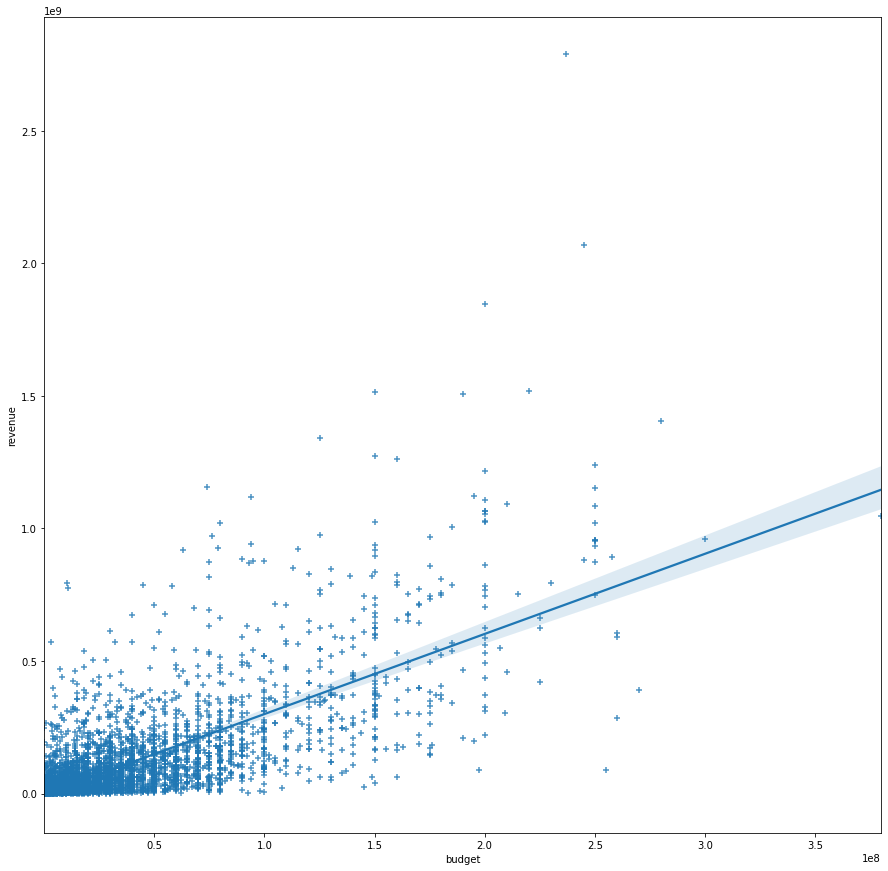

In [74]:
fig, ax = pyplot.subplots(figsize=(15,15))
ax = sns.regplot(x="budget", y="revenue", data=datas, marker="+")

This graph is a scatter plot that showed the relationship of the budget to the movie's revenue. The budget is measured in 100 million, and the revenue is measured in billions. As we can see from this graph, it is generally true that as the budget of the movie increases, the revenue will increase as well. We can see a positive correlation among those variables, and that is also one thing we can see out of the regression lines.

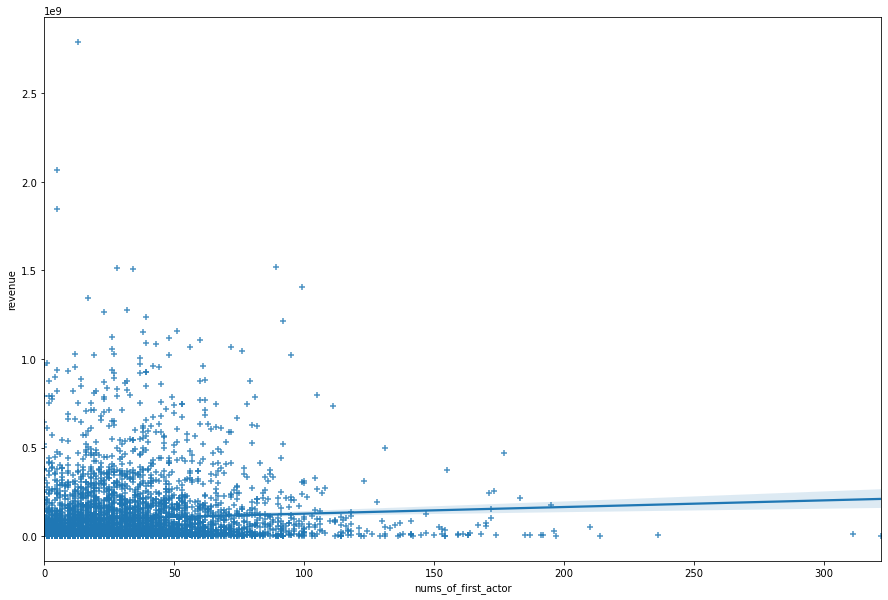

In [75]:
fig, ax = pyplot.subplots(figsize=(15,10))
ax = sns.regplot(x="nums_of_first_actor", y="revenue", data=datas, marker="+")

This graph is a scatter plot that showed the relationship of the number of movies that the main actor participated in before releasing the film to the movie's revenue. The revenue is measured in billions. As we can find out from the general shape of the scatter plot. There are cases that new, inexperienced actors will make a high revenue while some experienced actors cannot. But still, a weak correlation can be seen from the regression line, indicating that it is still a case, but relatively weak, that the number of movies they participated in will contribute to the movie's revenue.

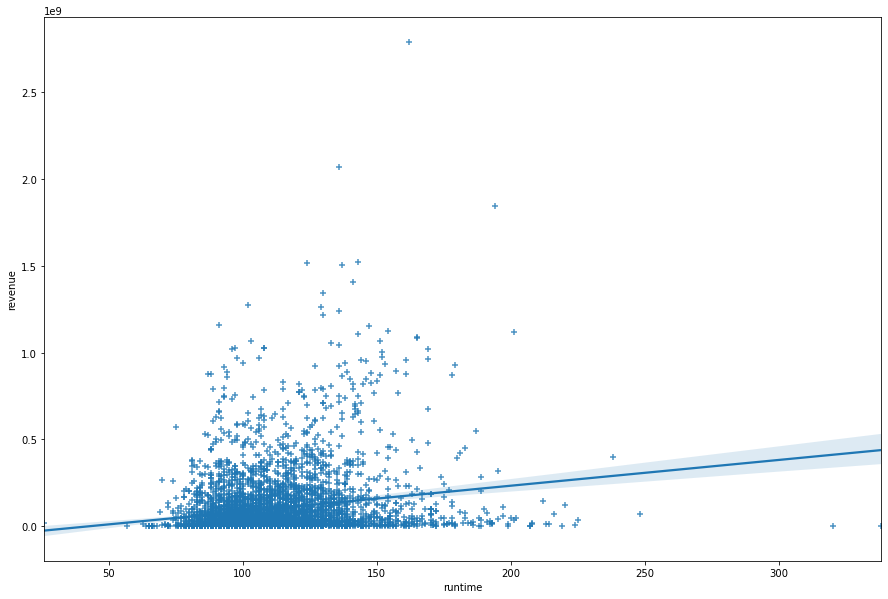

In [76]:
fig, ax = pyplot.subplots(figsize=(15,10))
ax = sns.regplot(x="runtime", y="revenue", data=datas, marker="+")

This graph is a scatter plot that showed the relationship of the movie's runtime to the movie's revenue. The revenue is measured in billions, and runtime is measured in minutes, as we can find out from the general shape of the scatter plot. It is made sure that there is indeed an optimal time for the movie. Longer movies are not a popular choice for everyone, and it seems that the optimal time for the movie is around 110-130 minutes. In this way, a single linear variable is not enough for fitting this trend, and thus we need a polynomial, probably quadratic, to fit this data. Also, this addresses the question that "How is the runtime of the film relate to the revenue?", it is highly probable that there is a quadratic relationship between runtime and revenue.

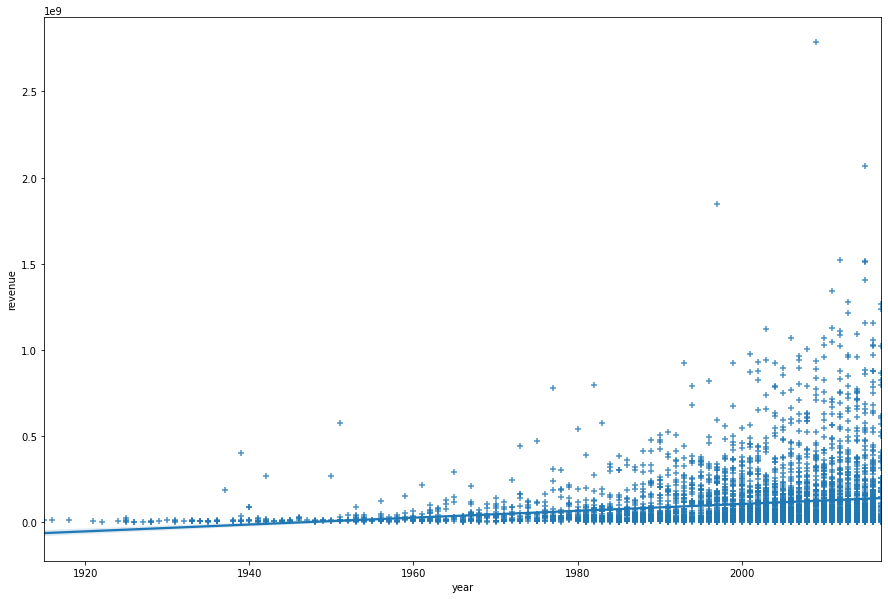

In [77]:
fig, ax = pyplot.subplots(figsize=(15,10))
ax = sns.regplot(x="year", y="revenue", data=datas, marker="+")

This graph is a scatter plot that showed the relationship of the year in which the movie is produced to the movie's revenue. The revenue is measured in billions, and runtime is measured in minutes. As we can find out from the general shape of the scatter plot, as the year increases, the revenue seems to increase in a way that is more than linear. This can be explained because firstly, as the year increases, people gain more and more knowledge and will be more able to make movies that make high revenue. Also, there may be the effect of inflation will affect the film. Thus, even a movie in 2020 is of the same quality as a movie in 1990; the former movie will make more revenue than the latter when counting the effect of inflation. In this way, a single linear variable is not enough for fitting this trend, and thus we need a polynomial, probably quadratic, to fit this data.

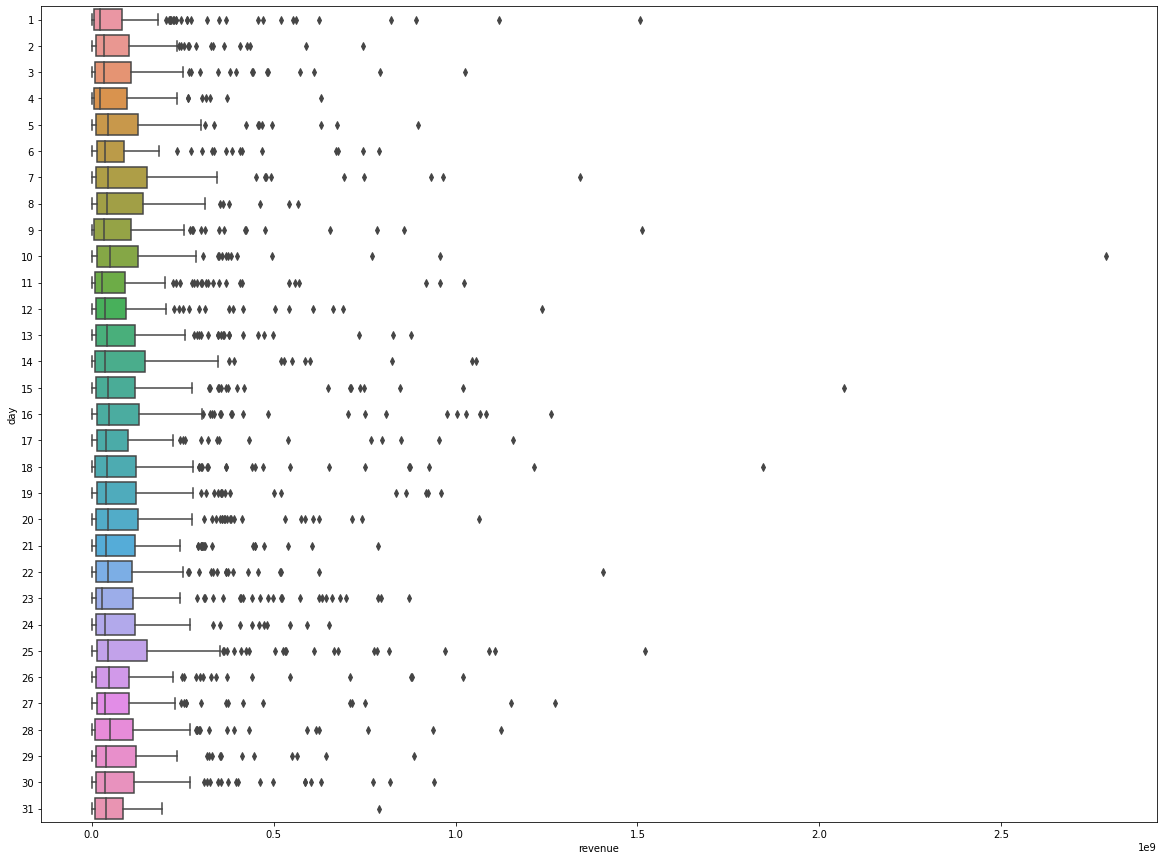

In [78]:
fig, ax = pyplot.subplots(figsize=(20,15))
data_sort_by_date = datas
data_sort_by_date["day"] = data_sort_by_date["day"].astype("int")
data_sort_by_date = data_sort_by_date.sort_values(by = "day", ascending = True)
data_sort_by_date["day"] = data_sort_by_date["day"].astype("str")


ax = sns.boxplot(y="day", x="revenue",  orient="h", data=data_sort_by_date)

This box plot tells the relationship between the day when the movie is released and the revenue. A box plot is a graph to show the distribution of the data and to check whether there are any outliers. To better analyze the chart, we put day to the y-axis and revenue to the x-axis. From a glance, we see a lot of outliers on the graph. This showed some randomness and unstableness of the movie revenue. It seems to be a general trend that most of the movies do not make too much revenue. Thus those movies that made high revenue will be considered as outliers.

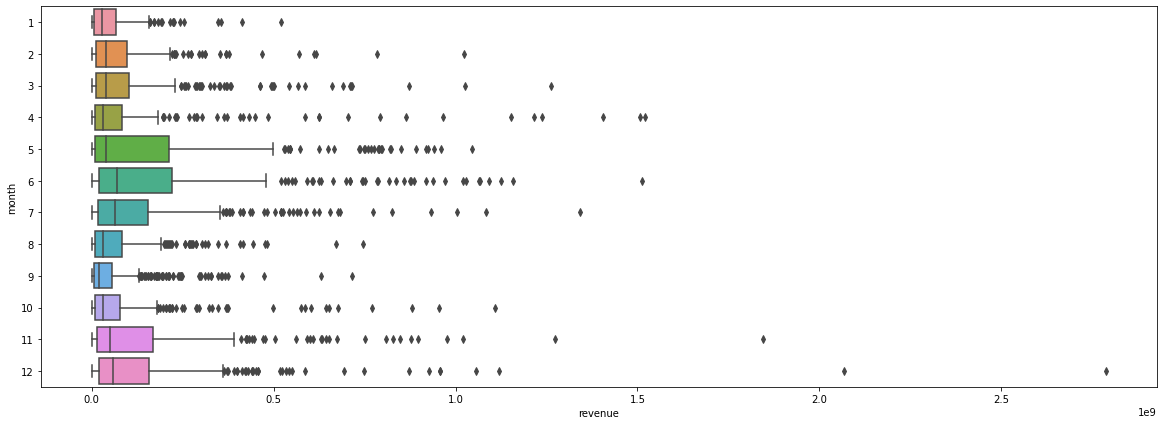

In [79]:
fig, ax = pyplot.subplots(figsize=(20,7))
data_sort_by_month = datas
data_sort_by_month["month"] = data_sort_by_month["month"].astype("int")
data_sort_by_month = data_sort_by_month.sort_values(by = "month", ascending = True)
data_sort_by_month["month"] = data_sort_by_month["month"].astype("str")


ax = sns.boxplot(y="month", x="revenue",  orient="h", data=data_sort_by_month)

This box plot tells the relationship between the month when the movie is released and the revenue. It showed the distribution of the revenue, categorized by the month. Firstly, there are still many outliers from looking, which means that it will be hard for us to predict the expected revenue. Also, we can see some difference in the month and the revenue made. From the graph, the spread of the revenue is more extensive in months 5,6,7, and 11,12. This probably means that there is much variation in the quality of movies presented in this period, probably with both good movies and bad movies.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'revenue'),
  Text(0, 1.5, 'budget'),
  Text(0, 2.5, 'runtime'),
  Text(0, 3.5, 'year'),
  Text(0, 4.5, 'nums_of_first_actor')])

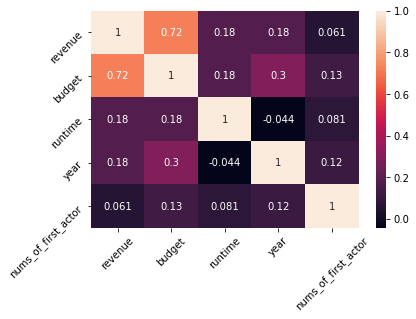

In [80]:
val_df = datas[["revenue", "budget", "runtime", "year", "nums_of_first_actor"]]

corr_df = val_df.corr()

graph = sns.heatmap(corr_df, annot=True)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

This figure is a heatmap, and it gives us a clear understanding of the correlation between the numeric variables. From this specific heat map, we can see that year, the runtime has a weak correlation to the movie's revenue, and there is almost no correlation between the movies the main actor participates in the revenue of the movie. Although this graph showed weak or nearly no correlation between feature and target, those effects of the variables will be further analyzed in the feature selection part.

Here we address the question of "Which feature has the highest correlation to the target variable, and which feature has the least correlation to the target variable?". As seen from the graph, the budget has the highest correlation to the revenue while the number of movies participated for the main actor has the lowest correlation.

One interesting thing is that year has a medium correlation with the budget, and that is explainable. As the year is growing, people generally make more money and thus will invest more in the movie production process. What is more, as the year increases, people will have more demand for good quality movies, and they will pay more for a good film. In this way, more budget will be allocated.

### 3.3. Model Training
First, we split the data using percentage split. Then we apply five regression algorithms, including Ridge Regression, kNN, Extra-trees Regressor, Bayesian Ridge Regression, and Random Forest Regressor on the training set to train the model.

In [81]:
from sklearn.model_selection import train_test_split

features = pd.merge(features_for_choose_poly, features_df, left_index = True, right_index = True)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)

In [82]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

estimators = {
    "Ridge" : Ridge(),
    "k-Nearest Neighbor" : KNeighborsRegressor(),
    "ExtraTreesRegressor" : ExtraTreesRegressor(),
    "Bayesian Ridge Regression" : BayesianRidge(),
    "Random Forest Regressor": RandomForestRegressor()
}

In [83]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def regressors_percentage_split():
    for estimator_name, estimator_obj in estimators.items():
        model = estimator_obj.fit(X=X_train,y=y_train)
        
        print(estimator_name + ":")
        print("\tR-squared value for training set: ", r2_score(y_train, model.predict(X_train)))   
        print("\tR-squared value for testing set: ", r2_score(y_test, model.predict(X_test)))
        print("\tMSE value for training set: ", mean_squared_error(y_train, model.predict(X_train)))   
        print("\tMSE value for testing set: ", mean_squared_error(y_test, model.predict(X_test)))
        print("")

In [84]:
regressors_percentage_split()

Ridge:
	R-squared value for training set:  0.7618144822021502
	R-squared value for testing set:  0.4103366211324456
	MSE value for training set:  7496722395391653.0
	MSE value for testing set:  1.5851925977526672e+16

k-Nearest Neighbor:
	R-squared value for training set:  0.6620579159531774
	R-squared value for testing set:  0.4272378253242035
	MSE value for training set:  1.0636490468615774e+16
	MSE value for testing set:  1.539757075151053e+16

ExtraTreesRegressor:
	R-squared value for training set:  1.0
	R-squared value for testing set:  0.43001343116676005
	MSE value for training set:  0.0
	MSE value for testing set:  1.5322954114398868e+16

Bayesian Ridge Regression:
	R-squared value for training set:  0.536119951151579
	R-squared value for testing set:  0.47097635771632373
	MSE value for training set:  1.4600299729090938e+16
	MSE value for testing set:  1.422174738737844e+16

Random Forest Regressor:
	R-squared value for training set:  0.9381947905179155
	R-squared value for tes

#### Interpretation:
Among our five algorithms, Random Forest Regressor has the best result with the R-squared value of 0.479 and Mean Squared Error of 1.39e+16 on the testing set. However, the model using ExtraTreesRegressor and Random Forest Regressor is overfitting as the training set's R-squared value is much higher than the testing set. ExtraTreesRegressor even has a 1.0 value which showing a high complexity. The models using KNN, Bayesian Ridge Regression could be considered underfitting since their R-squared values for both training and testing sets are low.

The reason why there is such high MSE will be explained in the following subsection, where we determine if it is applicable to do feature preprocessing. 

#### Variables preprocessing
In this subsection, we will discuss whether it is applicable for this data to use preprocessing methods. First, we used MinMaxScaler and StandardScaler to normalize and standardize the dataset. 

In [85]:
from sklearn.preprocessing import MinMaxScaler

def preprocessed_regression_MinMax():
    scaler = MinMaxScaler()
    
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for estimator_name, estimator_obj in estimators.items():
        model = estimator_obj.fit(X=X_train_scaled,y=y_train)
        
        print(estimator_name + ":")
        print("\tR-squared value for training set: ", r2_score(y_train, model.predict(X_train)))   
        print("\tR-squared value for testing set: ", r2_score(y_test, model.predict(X_test)))
        print("\tMSE value for training set: ", mean_squared_error(y_train, model.predict(X_train)))   
        print("\tMSE value for testing set: ", mean_squared_error(y_test, model.predict(X_test)))
        print("")
        
    return (X_train_scaled, X_test_scaled)

In [86]:
X_train_scaled, X_test_scaled = preprocessed_regression_MinMax()

Ridge:
	R-squared value for training set:  -9.568298434731744e+16
	R-squared value for testing set:  -1.0349342862115238e+17
	MSE value for training set:  3.011554935188083e+33
	MSE value for testing set:  2.78221478297271e+33

k-Nearest Neighbor:
	R-squared value for training set:  -16.839476576882525
	R-squared value for testing set:  -19.756675409250757
	MSE value for training set:  5.6148503407114925e+17
	MSE value for testing set:  5.5800189382440186e+17

ExtraTreesRegressor:
	R-squared value for training set:  -25.437510715687306
	R-squared value for testing set:  -30.350594424457405
	MSE value for training set:  8.321021382538857e+17
	MSE value for testing set:  8.427983150698326e+17

Bayesian Ridge Regression:
	R-squared value for training set:  5.631089501356712e-07
	R-squared value for testing set:  -0.00012039020517340404
	MSE value for training set:  3.14742820773961e+16
	MSE value for testing set:  2.688624554672991e+16

Random Forest Regressor:
	R-squared value for traini

Unfortunately, we found that this produces a negative r-square value, which is weird (as typically, the r-square value ranges between 0-1). This probably means that we should not apply MinMaxScaler to normalize our data.

In this way, we applied StandardScaler to standardize our variables and hope that works.

In [87]:
from sklearn.preprocessing import StandardScaler

def preprocessed_regression_Standard():
    scaler = StandardScaler()
    
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for estimator_name, estimator_obj in estimators.items():
        model = estimator_obj.fit(X=X_train_scaled,y=y_train)
        
        print(estimator_name + ":")
        print("\tR-squared value for training set: ", r2_score(y_train, model.predict(X_train)))   
        print("\tR-squared value for testing set: ", r2_score(y_test, model.predict(X_test)))
        print("\tMSE value for training set: ", mean_squared_error(y_train, model.predict(X_train)))   
        print("\tMSE value for testing set: ", mean_squared_error(y_test, model.predict(X_test)))
        print("")
        
    return (X_train_scaled, X_test_scaled)

In [88]:
X_train_scaled, X_test_scaled = preprocessed_regression_Standard()

Ridge:
	R-squared value for training set:  -1312157748532588.8
	R-squared value for testing set:  -1420791185610143.2
	MSE value for training set:  4.129924636333096e+31
	MSE value for testing set:  3.8195142365917798e+31

k-Nearest Neighbor:
	R-squared value for training set:  -15.978113607342202
	R-squared value for testing set:  -18.60938396135716
	MSE value for training set:  5.343742377304815e+17
	MSE value for testing set:  5.27159247395203e+17

ExtraTreesRegressor:
	R-squared value for training set:  -25.963451256014018
	R-squared value for testing set:  -30.5367655405273
	MSE value for training set:  8.486557484975529e+17
	MSE value for testing set:  8.478031548765053e+17

Bayesian Ridge Regression:
	R-squared value for training set:  5.074548661276879e-06
	R-squared value for testing set:  -0.00011610053155242106
	MSE value for training set:  3.1474140082990096e+16
	MSE value for testing set:  2.6886130227394948e+16

Random Forest Regressor:
	R-squared value for training set: 

However, as we can see from the above stats, all of the results are unreasonable by giving a negative value. So, it is not plausible for us to preprocess it in those ways.

The unreasonable result may be because the distributions of feature variables are far from a normal distribution, so StandardScaler cannot standardize the data into a usable format. Also, because the feature variables have some huge gap between the min and max value, the MinMaxScaler can't scale well either.

Now we can understand why there is a high MSE for the algorithm. As we fail to do any variable preprocessing and it is not applicable for us to do so. And as the range of the revenue is spread very far away, from almost under a million to several billion, it is somewhat common for us to get an MSE value that high.

#### Feature Selection
We apply the model-based selection with the threshold "mean" technique to select the subset of original features with importance higher than the mean importance of all features. Then we train our models with the selected features.

In [89]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor

def Model_feature_selection():
    select = SelectFromModel(DecisionTreeRegressor(random_state = 3000), threshold = "mean")
    
    select.fit(X_train, y_train)
    
    X_train_selected = select.transform(X_train)
    X_test_selected = select.transform(X_test)
    
    print("Selected features after Model-based feature selections:")
    masking = select.get_support()
    for i,feature_name in enumerate(features.columns):
        if masking[i] == True:
            print("\t" + feature_name)
    
    for estimator_name, estimator_obj in estimators.items():
        model = estimator_obj.fit(X=X_train_selected,y=y_train)
        
        print(estimator_name + ":")
        print("\tR-squared value for training set: ", r2_score(y_train, model.predict(X_train_selected)))   
        print("\tR-squared value for testing set: ", r2_score(y_test, model.predict(X_test_selected)))
        print("\tMSE value for training set: ", mean_squared_error(y_train, model.predict(X_train_selected)))   
        print("\tMSE value for testing set: ", mean_squared_error(y_test, model.predict(X_test_selected)))
        print("")
    
    return (X_train_selected, X_test_selected)

In [90]:
X_train_selected, X_test_selected = Model_feature_selection()

Selected features after Model-based feature selections:
	runtime
	runtime^2
	year
	year^2
	num
	budget
	x0_Action
	x0_Adventure
	x0_Animation
	x0_Comedy
	x0_Crime
	x0_Drama
	x0_Horror
	x2_1492 Pictures
	x2_Artisan Entertainment
	x2_Blue Sky Studios
	x2_Bookshop Productions
	x2_Canal+
	x2_Channel Four Films
	x2_Columbia Pictures
	x2_DreamWorks SKG
	x2_Dune Entertainment
	x2_Gold/Miller Productions
	x2_Ingenious Media
	x2_Kemp Company
	x2_Lionsgate
	x2_Lucasfilm
	x2_Miramax Films
	x2_New Line Cinema
	x2_Pacific Data Images (PDI)
	x2_Paramount Pictures
	x2_Pixar Animation Studios
	x2_Regency Enterprises
	x2_Screen Gems, Inc.
	x2_Silver Pictures
	x2_Spyglass Entertainment
	x2_Studio Babelsberg
	x2_Studio Ghibli
	x2_Tiger Aspect Productions
	x2_Touchstone Pictures
	x2_Twentieth Century Fox Film Corporation
	x2_Universal Pictures
	x2_Village Roadshow Pictures
	x2_Weed Road Pictures
	x2_WingNut Films
	x3_Australia
	x3_Canada
	x3_China
	x3_France
	x3_Hong Kong
	x3_United Kingdom
	x3_United Sta

#### interpretation: 

Firstly, from the variable retained, we can see some interesting effects. For example, all the x1 features are eliminated. From checking, we know that the column label is languages. Thus we know that the wording does not correspond to the revenue of the movie. To explain this effect, it is possible that in whatever language we produce this movie. It will all be translated to English, as long as it is popular enough. Also, a film in the local languages may attract more local people, compensating for the loss.

Also, we found that all the popular genres among the production (drama, comedy, and action) are selected as important features to evaluate the movies from the selected genre. It is possible to deduce that people will love to watch those movies, and the film with such genres will tend to get a significant boost in revenue.

Another thing to notice is that all of the numeric features, including the polynomials, are retained. This gives us the understanding that all of the numbers are necessary to make a prediction. Even though statistically, there is not too much correlation between the features and target, as we are using algorithms using a decision tree, the decision tree may capture the hidden pattern inside the data.

Lastly, to analyze the effect of the feature selection. We can see that there is only a subtle change in the performance of the models before and after the feature selection. For example, for the Random Forest Regressor, the testing set's R-squared value changed from 0.4957 to 0.4847. Even though some models showing a slightly decreased performance, the feature selection process is still worthy since, after feature selection, the runtime is far less than before feature selection because we remove lots of unimportant features that have less or no impact on the revenue. Thus, feature selection is a good choice for our model's performance.

In the end, there are two possible candidates which we will use, one is random forest regressor, and the other is Bayesian Ridge Regression as those two have the similar highest r-square without much difference. Random Forest Regression is overfitting while Bayesian Ridge Regression is underfitting. We are going for the Random Forest Regressor as overfitting means that probably when we generalize the model a bit more, it will be easy for the model to cover a wider variety of data. However, to overcome underfitting, we might need to find ways to increase the complexity, like creating more features, and it is hard for us to achieve those jobs. Thus, Random Forest Regressor will be used and sent to hyperparameter tuning.  


### 3.4. Model Optimization


This subsection aims to improve the performance of this model through hyperparameter tuning. The internal reasons behind this are that from the current metric of MSE and R-square, the model explained many variations for the training set (around 90%), but not many variations for the testing set are explained (around 47%). Thus this model still suffers from overfitting, and we wish to address this issue through hyperparameter tuning.

The parameter that we use is max_depth and min_samples_leaf. Max_depth controls the maximum depth of the tree, the deeper the tree, the more complex this model is, and it will be more likely to suffer from overfitting. Min_samples_leaf controls the minimum number of samples required to be at a leaf node. The smaller the value, the more complex the final tree will be, and the more likely it suffers from overfitting.

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

def grid_search_RFR():
    pram_grid = {"max_depth":[50, 60, 70, 80, 90, 100], "min_samples_leaf":[1, 2, 3]}
    kfold = KFold(n_splits = 5, random_state = 2000, shuffle = True)
    
    grid_search = GridSearchCV(RandomForestRegressor(), pram_grid, cv=kfold)
    
    grid_search.fit(X=X_train_selected, y=y_train)
    
    print("Best cross-validation score: ", grid_search.best_score_)
    print("Best parameters: ", grid_search.best_params_)
    # print("Training set score with best parameters: ", grid_search.score(X_train_selected, y_train))
    # print("Test set score with best parameters: ", grid_search.score(X_test_selected, y_test))
    
    return grid_search.best_params_

best_set = grid_search_RFR()

Best cross-validation score:  0.5710643974101893
Best parameters:  {'max_depth': 100, 'min_samples_leaf': 3}


### 3.5. Model Testing 

In [92]:
def test_tuned_pram():
    best_max_depth = best_set["max_depth"]
    best_min_leaf = best_set["min_samples_leaf"]
    
    model = RandomForestRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_leaf).fit(X=X_train_selected,y=y_train)
    print("\tR-squared value for training set: ", r2_score(y_train, model.predict(X_train_selected)))   
    print("\tR-squared value for testing set: ", r2_score(y_test, model.predict(X_test_selected)))
    print("\tMSE value for training set: ", mean_squared_error(y_train, model.predict(X_train_selected)))   
    print("\tMSE value for testing set: ", mean_squared_error(y_test, model.predict(X_test_selected)))
    
test_tuned_pram()

	R-squared value for training set:  0.8311239912968102
	R-squared value for testing set:  0.493726198644894
	MSE value for training set:  5315254127096164.0
	MSE value for testing set:  1.361016320676884e+16


<a id="5"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 4. DISCUSSION

#### Findings Interpretation

We compared five regression algorithms, including Ridge Regression, kNN, Extra-trees Regressor, Bayesian Ridge Regressor, and Random Forest Regressor. After feature selection and getting the output, we found that Random Forest Regressor has the best performance among those five regression algorithms. Then, we use two hyperparameter tuning, which is max depth and min samples leaf, on this algorithm to tune our model, and found that the best parameters for max depth are 100 and for min samples leaf is 3. We get 83.1% R-squared on the training set, 49.3% R-squared on the testing set for the final result, 5.31e+15 Mean Squared Error on the training set, and 1.33e+16 Mean Squared Error on the testing set. Although feature selection lead to slighly worse result, we decide to choose it as it saves huge amount of time.

Random Forest Regressor perform better because it has the higher accuracy by creating many decisions tree during the data set and uses the mean class as he predictions of all trees. And it avoids overfitting and decreases the variance. We don't choose the other four algorithms because there are specific differences and limitations between the algorithm and our model. For Ridge algorithm, it is based on linear regression. However, our dataset is too complicated to simply use linear regression to generate the model. For k-Nearest Neighbor, it cannot perform well on analyzing sparse data. After using one-hot encoding, we got lots of sparse data, so it's not an excellent choice to use the k-Nearest Neighbor regressor. For Extra Trees Regressor, it uses the whole original sample, so it will increase the variance and probably make an over-complex model that can predict a few cases. Also, from the result in the training set, we see that the R-squared value is 1 and the Mean Squared Error is 0, which indicates an overfitting model. Bayesian Ridge Regression is based on probability and will perform well on a large dataset. However, our dataset is not big enough for Bayesian Ridge Regression to take advantage of, and also this will lead the result more spread out.

Based on our findings, maybe people cannot use the features in our dataset to predict the outcome variable we identified using the algorithms we've applied. Because even our algorithm has given the highest score of R-squared and lowest score of Mean Squared Error, our model can only provide a roughly 50% variance explained. Analyzing our model, we found that there is a problem of overfitting the algorithm. It is probably not the case that there are too many features for the algorithms to form a model. However, it is perhaps the case that the features we choose do not give meaningful information on how to predict the revenue, so that the model will try to generalize the model on a meaningless pattern, like a particular combination of the feature within a specific range that we cannot have a good understanding. This issue is being amplified when we use the random forest as a regressor since random forest is based on decision trees, and the nature of decision trees allows it to adapt to every situation and feature input, no matter how bad the feature is. When selecting features, we only choose the information that can be provided before the movie is published, so some important features such as popularity, rating, and movie reviews will not be included. Due to the subjective attributes of those features, those features probably cannot provide enough clues to determine the revenue. Also, by comparing Saba Tavoosi's work, we should add more features to our dataset, such as number of genres, number of keywords, number of the female cast, number of the male cast, etc. Those features probably provide more information about predicting the revenue, and those data are available even if the movie is not released. Since we are missing those features, it will make our model become simple and suffers from overfitting.


#### Conclusion & Future Work

In summary, we use a linear regression algorithm to predict a new film's revenue based on the movie dataset we found on Kaggle. Through wrangling and analyzing our data, we generate lots of informative visualizations. We applied five algorithms on this model after features selection, and through comparing the R-squared results and Mean Squared Error, we finally select the Random Forest algorithm on the model. By hyperparameter tuning, we choose max depth with 100 and min samples leaf with 3. Due to some limitations on our original dataset, our model suffers from overfitting, and the testing result is roughly around 50%.

After generating our model, and conducted hyperparameter tuning, we found that our prediction model still suffers from overfitting, with the reasons stated above. By comparing Saba Tavoosi's work, we found a potential reason that causes this problem, which is missing important features. So in our future work, we will try to add more features and select some representative data to train our model to address overfitting. Also, the dataset we found is not that perfect due to lots of movies have extremely low revenues, and even some high-revenue movies are mistakenly considered outliers. Thus, we will find a more optimal dataset or only analyze well-known films to increase the performance of our model.

### CONTRIBUTIONS

* Wenting Yue: Write the executive summary, question part in introduction, data analysis in method part, feature engineering and data model training interpretation in result part, contributes lots of ideas on discussion part.


* Xiaofei Xie: Revise the introduction part and do some research about the previous work and summarize it. Write data acquisition in method part and data wrangling interpretation in result part. Write the whole section of the discussion, including findings, performance, conclusion, and future works.


* Zenghui Sun: Find the dataset, scrapped the data in the Method part, and upload the link into GitHub. Do the data processing and analysis, including data wrangling, data exploration, data training, model optimizing, and model testing. And write data exploration interpretation.